#### Functions (IGNORE)

##### Functions for Downloading Data
- 'get_data_from_start_to_end': Load in the data from YFinance API
- 'download_stock_data_for_periods': Look at different periods to understand how technical analysis changes throughout changes in macroeconomy
- 'get_adjusted_closed_price' : Get the dataframe of adjusted closed price with columns as ticker and row as date. 

In [1]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [2]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [3]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Descriptive Analytics

In [4]:
# create a function to get a table of descriptive analysis of the different sector etfs in different time periods

# import pandas 
import pandas as pd

def create_analysis(tickers,periods,nested_dict,col_name,function_name):
    """
    parameters:

    tickers: the list of tickers that will be looped through
    periods: the list of periods that will be looped through
    nested_dict: the dictionary which can be accessed through nested_dict[period][ticker]
    col_name: the column of the nested dictionary
    function_name: the function that you want to be applied

    returns:
    a dataframe with columns as time periods and rows as sector etfs with the column name within the nested dictionary with a descriptive statistic applied
    """
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = nested_dict[period][ticker][col_name]
            df.at[ticker, period] = getattr(pd.Series(data), function_name)()
    return df

##### Visualising Data

In [5]:
import plotly.graph_objects as go

def visualize_candlestick(data, title="Candlestick Chart"):
    """
    Visualizes candlestick data using Plotly.

    Parameters:
    data (pd.DataFrame): The dataframe containing the stock's OHLC data. 
                         It should contain 'Open', 'High', 'Low', and 'Close' columns.
    title (str): The title of the plot.

    Returns:
    fig: The Plotly figure object.
    """
    fig = go.Figure(data=[go.Candlestick(x=data.index,
                                         open=data['Open'],
                                         high=data['High'],
                                         low=data['Low'],
                                         close=data['Close'])])

    # Set titles and labels
    fig.update_layout(title=title,
                      xaxis_title='Date',
                      yaxis_title='Price',
                      xaxis_rangeslider_visible=False)
    
    fig.show()

    return fig

##### Stock Trading Strategies

In [6]:
import numpy as np

def buy_hold_roi(nested_dict, periods, tickers, column):
    """
    Objective: 
    To return the ROI when purchasing stocks during different economic time periods.
    
    Parameters:
    nested_dict: holds the historical data
    periods: a list of time periods to be used as columns
    tickers: a list of tickers to be used as rows

    Returns:
    DataFrame with the ROI using a buy and hold strategy.
    """
    # Create a DataFrame to give the ROI for different investments
    roi = pd.DataFrame(index=tickers, columns=periods)

    # Sort through each ticker and each period
    for ticker in tickers:
        for period in periods:
            # Get the DataFrame through the nested dictionary
            data = nested_dict.get(period, {}).get(ticker)

            # Make sure that the data is present
            if data is not None and column in data.columns:
                start_price = data[column].iloc[0]
                end_price = data[column].iloc[-1]

                start_date = data.index[0]
                end_date = data.index[-1]

                num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days

                if num_days > 0:  # Ensure we don't divide by zero
                    # Calculate percentage difference 
                    total_return = ((end_price - start_price) / start_price) * 100
                    annualized_roi = ((1 + total_return / 100) ** (365 / num_days) - 1) * 100  # Annualized percentage
                    roi.at[ticker, period] = annualized_roi
                else:
                    roi.at[ticker, period] = np.nan
            else:
                roi.at[ticker, period] = np.nan

    return roi


In [7]:
import random

def stochastic_modeling(nested_dict, tickers, periods,num_samples):
    # Store the returns in a nested dictionary
    nested_dict_returns = {period: {ticker: [] for ticker in tickers} for period in periods}

    # Go through each economic time period
    for period in periods:
        max_index = len(nested_dict[period]) - 30  # Ensure there's enough data to calculate ROI

        # Generate random samples from the valid range
        random_dates = random.choices(range(max_index), k=num_samples)

        for ticker in tickers:
            for date_idx in random_dates:
                start_price = nested_dict[period][ticker].iloc[date_idx]
                end_price = nested_dict[period][ticker].iloc[date_idx + 30]

                # Get the return by the Holding Period Return
                roi = (((end_price - start_price) / start_price) * 100)

                nested_dict_returns[period][ticker].append(roi)

    return nested_dict_returns  # Return the nested dictionary with returns

In [41]:
def stochasting_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

# EDA and Data Cleaning

#### Assignment: Exploratory Data Analysis (EDA) and Data Cleaning Report

## Dataset Overview:

### Yahoo Finance API

The data that will be used for my capstone can be accessed through the Yahoo Finance API.

The Yahoo Finance API is a free popular API that is used by developers to load in a variety of stock data. This includes financial, candlestick and other information that can be utilized to make informed investment decisions.

Yahoo Finance is free and very easy to set up. First pip install yfinance and then simply load it into your notebook.


In [9]:
# load the API in
import yfinance as yf # yf is the usual name for the package

The YFinance API offers stock candlestick data, information about the stock as well as financial/balance sheets. This can be utilised to create a number of analysis such as fundamental and technical analysis. This project will have a concentration in technical analysis which looks at the price of the stock. 

#### Candlestick Data
Candlestick data is used for a variety of techniques in investing as it holds the crucial information associated with the price of the stock throughout the trading day. This can be used to create a deeper understanding of how the stock changes on a day to day basis.

The columns contain candlestick data which is:

- 'Open' : The price of the equity at the beginning of the trading day.
- 'High' : The highest price of the equity throughout the day.
- 'Low' : The lowest price of the equity throughout the day.
- 'Close' : The price of the equity at the end of the trading day
- 'Adjusted Close' : The came as closing price however it takes dividends, stock splits and new stock offerings into account
- 'Volume': The number of times that equity is traded within a day.

In [10]:
# save the ticker information of 'MSFT' as a variable
msft = yf.Ticker('MSFT')

# download the candlestick data
msft_candlestick = yf.download('MSFT', start='2020-01-01', end='2024-01-01')

# display the dataframe
msft_candlestick

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,153.938217,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.021408,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.414368,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.024658,21634100
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.430237,27746500
...,...,...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987,372.543915,17091100
2023-12-26,375.000000,376.940002,373.500000,374.660004,372.623505,12673100
2023-12-27,373.690002,375.059998,372.809998,374.070007,372.036713,14905400


#### Stock Information
The general information that is associated with a company can be a part of evaluating the current equity of a stock. This has essential information which can be used for analaysis but also to understand the parameters of the stock. This can be done to create subgroups of the demographics.

In [11]:
# .info can be used for information about the company
print(msft.info)

{'address1': 'One Microsoft Way', 'city': 'Redmond', 'state': 'WA', 'zip': '98052-6399', 'country': 'United States', 'phone': '425 882 8080', 'website': 'https://www.microsoft.com', 'industry': 'Software - Infrastructure', 'industryKey': 'software-infrastructure', 'industryDisp': 'Software - Infrastructure', 'sector': 'Technology', 'sectorKey': 'technology', 'sectorDisp': 'Technology', 'longBusinessSummary': 'Microsoft Corporation develops and supports software, services, devices and solutions worldwide. The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, and other office services. This segment also provides LinkedIn; and dynamics business solutions, including Dynamics 365, a set of intelligent, cloud-based applications across ERP, CRM, power apps, and pow

#### Balance Sheets
The financial and balance sheets of an equity are must be released so that investors can make educated decisions when looking at which stock to invest in.

In [12]:
# .get_balance_sheets returns the balance sheet information
print(msft.get_balance_sheet()[0:5])

                          2024-06-30      2023-06-30     2022-06-30  \
OrdinarySharesNumber    7434000000.0    7432000000.0   7464000000.0   
ShareIssued             7434000000.0    7432000000.0   7464000000.0   
NetDebt                33315000000.0   12533000000.0  35850000000.0   
TotalDebt              67127000000.0   59965000000.0  61270000000.0   
TangibleBookValue     121660000000.0  128971000000.0  87720000000.0   

                         2021-06-30  
OrdinarySharesNumber   7519000000.0  
ShareIssued            7519000000.0  
NetDebt               43922000000.0  
TotalDebt             67775000000.0  
TangibleBookValue     84477000000.0  


### Stock Data
There are thousands of equities to choose from on the stock market, to reduce the overload of data that will be used in training the trading techniques sector ETF's will be used instead.

#### Exchange Traded Funds (ETF)
Electronically Traded Funds or ETF's are an investment equity which has a basket of securities that tracks or seeks to outperform indexes. It takes a smaller proportion of a large number of individual stocks so that the equity is a broader representation of a specific idea. For example if you want to invest in small-cap companies, there are a number of ETF's that can be used to take a smaller investment of a hundred companies rather than one. This looks to spread out investments to reduce risk.

#### Economic Time Periods
The macroeconomic business cycle is the representation of overall economic activity within the economy. During different periods of economic activity the market sectors will react differently. The following are the typical components of the macroeconomic business cycle.

- Trough : This is the low point of the economy where supply is in excess and demand is in shortage. This can turn into a recession which is where there are two consecutive quarters where the GDP growth is negative.

- Expansion : Following a trough, there is a period of economic growth which leads to an increase in consumer and business confidence. This will result in an increase in wage growth and a decrease in unemployment. Expansion periods should be steady and not exponential to ensure prolonged prosperity.

- Peak : A peak occurs when an expansion has reached its limit and there ends up being downward pressure on the growth rate within economic activity. Businesses will then reevaluate their decision making to review budgets and other outlooks.

- Contraction : This is when growth slows, unemployment increases and business investment falls. 


In [13]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction']

#### GICS Sectors
According to Global Industry Classification Standard there are 11 major sectors at play within the economy. Each with their own industries and sub-industries but this capstone project there will be a concentration on the sectors. 

For the capstone project a concentration on ETF's that represent the sectors will be used to help understand how different sectors will perform. The following ETF equities are going to be invested in based on their sector. More information about the equities can be found in the report.

- Materials : XLB 
- Industrials : XLI
- Financials : XLF
- Information Technology : XLK
- Consumer Discretionary : XLY
- Consumer Staples : XLP
- Energy : XLE
- Healthcare : XLV
- Communication Services : VOX
- Utilities : XLU
- Real Estate : IYR

In [14]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

### Nested Dictionary Storage of Relevant Data
Using the YFinance API load in candlestick data with the 11 industry sectors during the four different economic time periods. This can be used to evaluate sector etfs during different economic time periods using the daily adjusted closed price.

In [15]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [16]:
# navigate the nested dictionary
sector_etf_data

{'trough': {'XLB':                  Open       High        Low      Close  Adj Close    Volume
  Date                                                                       
  2008-10-01  32.759998  33.189999  32.130001  32.849998  23.222450  14639500
  2008-10-02  31.540001  31.860001  29.930000  30.490000  21.554113  12581300
  2008-10-03  30.190001  31.690001  29.780001  30.190001  21.342041  16770600
  2008-10-06  29.510000  29.510000  26.889999  28.700001  20.288729  22512700
  2008-10-07  29.160000  29.530001  27.049999  27.219999  19.242470  16004900
  ...               ...        ...        ...        ...        ...       ...
  2009-05-22  26.530001  26.660000  26.110001  26.299999  18.932846   8421500
  2009-05-26  26.170000  26.969999  25.830000  26.930000  19.386358   7886900
  2009-05-27  26.790001  26.850000  25.860001  25.920000  18.659290   7216600
  2009-05-28  26.190001  26.440001  25.760000  26.379999  18.990433   8773400
  2009-05-29  26.670000  27.200001  26.500000  

#### Missing Data Values
'download_stock_data_for_periods' function checks to make sure if there are any missing dates for any of the stocks it will return a dataframe with those that are missing. However each sector etf seems to have all data so there is no missing data.

#### Accessing specific data
The following is an example of how you can access the healthcare 'XLV' sector ETF during the trough time period.

In [17]:
# access healthcare sector during an expansion
# first load in the trough data
trough_sector_data = sector_etf_data['trough']

In [18]:
# now access the healthcare sector etf 'XLV'
trough_sector_data['XLV'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,23.013000,6053600
2008-10-02,30.250000,30.590000,29.930000,30.299999,23.051037,6353400
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.556547,6814400
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.712105,8545000
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.187181,5060200


This returns the candlestick data for the XLV equity during a trough which ranged from 2008-01-02 to 2009-6-30 due to the Global Financial Crises. 

The same process can be completed in one step.

In [19]:
# access 'XLV' equity in one line of code
sector_etf_data['trough']['XLV'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,23.013000,6053600
2008-10-02,30.250000,30.590000,29.930000,30.299999,23.051037,6353400
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.556547,6814400
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.712105,8545000
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.187181,5060200


This is extremely useful for technical analysis which is heavily reliant on historical data. There is now an easy process to access any stock data's candlestick data (in this case sector ETF's) during any time period (different macroeconomic time periods). This is going to be used to as a basis for the capstone project. 

There are currently 6 columns however this will grow as different techniques require new columns to be used as features. 

The size of the data currently stands at: 4 time periods which as 
- 166 (trough)
- 754 (expansion)
- 169 (peak)
- 209

This is equal to 1298 trading days. Each trading day has 11 sector ETF's each with 6 columns which is 114,224 data points.

## Initial Data Inspection / Univariate Analysis
The dataset is a nested dictionary with a number of time series. Using typical descriptive statistics might not be as relevant. Using the create_analysis function you are able to load in the nested dictionary and apply different descriptive statistical reports on the different sector etfs during different time periods as a table. This can be adjusted to fit a number of descriptive statistics and for different parameters within the dataframe of the nested dictionary.

### Numerical Analysis

#### Initial Numerical Analysis
Looking at the descriptive statistics of the different sector etfs during different time period can help observe how the data changes from the beginning to the end of the period. This will be helpful for initial understanding of how investments change during different macroeconomic cycles.

In [20]:
# get the mean value of these stocks during the different time periods
mean_data = create_analysis(sector_etf_tickers,economic_cycle_periods_list,sector_etf_data,'Adj Close','mean')
mean_data

,trough,expansion,peak,contraction
XLB,16.686582,33.341455,52.917293,28.608563
XLI,15.852843,36.435796,72.431897,26.289617
XLF,6.886585,12.601652,25.941764,14.533609
XLK,12.620077,28.430873,79.864513,18.592997
XLY,16.963294,49.350607,116.163152,25.01046
XLP,14.870896,29.717787,53.480787,17.960932
XLE,28.421203,53.23693,47.020173,46.356162
XLV,19.386921,41.449805,87.094059,24.519837
VOX,31.093878,62.755678,85.677095,44.45534
XLU,15.769571,26.847841,53.767981,22.055004


The initial table can display the sector etfs and their mean values across the given time periods.

In [21]:
# get the median value of these stocks
median_data = create_analysis(sector_etf_tickers,economic_cycle_periods_list,sector_etf_data,'Adj Close','median')
median_data

,trough,expansion,peak,contraction
XLB,16.347618,32.295513,52.799812,28.447906
XLI,16.113986,35.817593,71.974785,26.422626
XLF,6.943472,13.03797,25.566187,14.805957
XLK,12.470977,27.19953,77.621559,18.339048
XLY,16.923285,50.454159,116.364227,25.156828
XLP,14.960622,30.248541,53.487617,18.00218
XLE,28.328444,53.228483,46.977001,45.894329
XLV,19.492287,41.068954,84.821198,24.091341
VOX,30.996971,64.178997,84.958977,43.722988
XLU,15.865279,26.341282,53.986687,22.073473


The initial table can display the sector etfs and their median values across the given time periods.

In [22]:
# get the difference between these two to decide if the mean and median are close
mean_data-median_data

,trough,expansion,peak,contraction
XLB,0.338964,1.045942,0.117481,0.160657
XLI,-0.261143,0.618204,0.457112,-0.133009
XLF,-0.056887,-0.436318,0.375577,-0.272348
XLK,0.149101,1.231343,2.242953,0.253948
XLY,0.040008,-1.103552,-0.201076,-0.146368
XLP,-0.089725,-0.530754,-0.006831,-0.041248
XLE,0.09276,0.008447,0.043171,0.461833
XLV,-0.105365,0.38085,2.272862,0.428496
VOX,0.096907,-1.423319,0.718118,0.732352
XLU,-0.095709,0.50656,-0.218706,-0.018469


Notice that the mean and median values are very close together which means that the typical value of a stock is likely normally distributed where there are data values that above and below the average with common occurence.

In [23]:
# how does the mean value change during the different states of the macroeconomic cycle
mean_data.mean()

trough         17.959496
expansion      38.249084
peak           68.625438
contraction    27.633456
dtype: float64

The mean values of the sector etf's return what is to be expected. The trough has the lowest prices, the peak has the highest prices. Meanwhile the contraction is on the lower end and the expansion is on the upper end.

In [24]:
# get the standard deviation
create_analysis(sector_etf_tickers,economic_cycle_periods_list,sector_etf_data,'Adj Close','std')

,trough,expansion,peak,contraction
XLB,1.8369,4.834145,1.567754,1.689659
XLI,1.812336,6.592581,3.025955,1.449261
XLF,1.60123,2.353624,1.424399,1.822996
XLK,0.955407,4.112598,6.027887,1.242621
XLY,1.718796,9.03084,3.309262,1.311233
XLP,0.887215,4.054363,1.675483,0.437353
XLE,2.229603,6.899178,1.668784,3.921772
XLV,1.066656,9.149628,4.82924,1.223716
VOX,2.207266,8.344901,3.730777,3.540011
XLU,1.029368,3.061783,2.171691,1.239613


This is heavily impacted by the time of which the stock is held on for. As expasnion goes for a longer period of time the standard deviation is higher, so this is not the most useful statistic (for now).

In [25]:
# get the min for each stock
create_analysis(sector_etf_tickers,economic_cycle_periods_list,sector_etf_data,'Adj Close','min')

,trough,expansion,peak,contraction
XLB,12.936708,25.420235,48.822552,23.116415
XLI,11.310505,26.419207,66.340546,22.242886
XLF,3.780495,8.54141,23.495205,10.250639
XLK,10.51297,21.661146,67.064919,15.143774
XLY,13.169908,33.7714,104.762817,21.546104
XLP,12.749028,22.914066,48.905937,17.105051
XLE,23.203632,39.914352,43.396389,36.121536
XLV,16.746855,28.426876,79.929436,22.719435
VOX,24.479908,47.675549,77.397789,36.699165
XLU,13.078053,22.511076,49.74073,18.577522


The lowest price of the adjusted close

In [26]:
# get the max for each stock
create_analysis(sector_etf_tickers,economic_cycle_periods_list,sector_etf_data,'Adj Close','max')

,trough,expansion,peak,contraction
XLB,23.22245,41.566238,56.028214,32.200748
XLI,21.9293,48.189209,78.330177,28.963064
XLF,12.458468,16.926832,28.394541,18.533941
XLK,15.67779,37.494656,93.997894,21.672707
XLY,22.636209,65.233078,123.11573,27.893875
XLP,18.105213,38.393642,56.881199,18.856041
XLE,37.702053,68.046051,50.070972,54.416748
XLV,23.051037,60.622334,97.517143,27.53071
VOX,36.781963,76.104355,94.986649,53.203083
XLU,18.792992,35.942581,59.973782,24.436253


The highest price of the adjusted close

### Visualisation
Creating a dashboard that can be used to adjust different time periods/stocks to visualise your stock data through candlestick data would be extremely useful. This will be done later. For now use the 'visualize_candlestick' function to plot candlestick data.

In [27]:
# create a sample visualisation of 'XLV' healthcare ETF from 2009-06 to 2010-01-01
for period in economic_cycle_periods_list:
    visualize_candlestick(sector_etf_data[period]['XLV'],f'XLK {period}')

Observe the movement of the XLK healthcare sector etf and how it changes during different macroeconomic time periods. Good for initial inspection to averaging all of the stocks during the different macroeconomic cycles will be a better representation of the movement of the market.

## Stock Investment: Buy and Hold
An extremely popular type of investment is a passive one, this is where individuals will see an opportunity for long term growth of an equity and will simply purchase the stock and hold onto it for a varied period of time. As the beginning component of analysis, use a buy and hold strategy to look at the different stocks during different time periods to determine yearly return on investment 

### Return on Investment Simple Model
The simple model is going to pruchase the sector etf at the start of the time period, then hold onto it. This is extremely reliant on the time the stock is purchased and is simply down to luck. However, it is going to show a rough udnerstanding of how the price of the stock changes. The timing has a bit of wiggleroom so that it goes from the previous cycle to the current cycle to represent how it changes.

In [28]:
buy_hold_roi(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,'Adj Close')

,trough,expansion,peak,contraction
XLB,-22.97904,14.67682,11.802967,-20.770545
XLI,-33.796274,20.419993,20.975959,-23.04329
XLF,-53.252206,25.012733,25.408899,-38.349921
XLK,-13.845802,19.182312,59.557897,-27.193486
XLY,-23.365393,24.228072,23.5748,-21.081165
XLP,-22.774027,17.478544,22.909515,-3.638238
XLE,-23.477646,5.689464,-7.317912,-15.718607
XLV,-19.875653,27.096288,24.263881,-18.572934
VOX,-8.72577,13.37129,26.766945,-33.074439
XLU,-24.913861,14.433969,31.706858,-24.292185


### Stochastic Numerical Analysis
The downside of the initial numerical analysis is that it only takes in one event of where you buy at the start of the period and sell at the end of the period. This is going to make time period and time of investment be a parameter which impacts the expected return. To overcome this stochastic modeling can be performed.

By performing a stochastic model where different time periods of initial investment and holding onto the equity for a set period takes away the included parameters. This isolates the expected return more. It can also be repeated over a number of samples which can then increase the likeliness of it being a true representation of the data. A histogram can also be created to observe how different returns on investment are observed. This probabilistic value can be used to display the probability distribution function and a cumulative distribution function can be created.

#### Calculating Expected Returns
The 'stochastic_modeling' function is going to go through each equity during each time period and take n samples of initial start dates and purchase one sector ETF. This is held for a month and then sold off. By repeating the model 1000 times you get a distribution of returns which can be used to understand expected returns and standard deviations which is essential for understanding which sector is best for different time periods and to understand how the data isdistributed.

In [29]:
# create an adjusted close price sector etf dictionary which can changed based on the macroeconomic period
adjusted_close_sector_etf = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

In [30]:
# take 1000 samples of different initial purchase dates, hold the equity for 30 days then compare it with the start
expected_values_sector_etf_buy_hold = stochastic_modeling(adjusted_close_sector_etf,sector_etf_tickers,economic_cycle_periods_list,10000)
expected_values_sector_etf_buy_hold['trough']['XLK'][0:5]

[-4.8734211820485225,
 13.239550553482529,
 2.5232146591181914,
 21.88192051505601,
 1.8388981116566727]

#### Visualising Expected Returns
A dashboard is going to be used to create a visualisation of any sector etf during any time period however the following will display one sector etf during the different economic time periods.

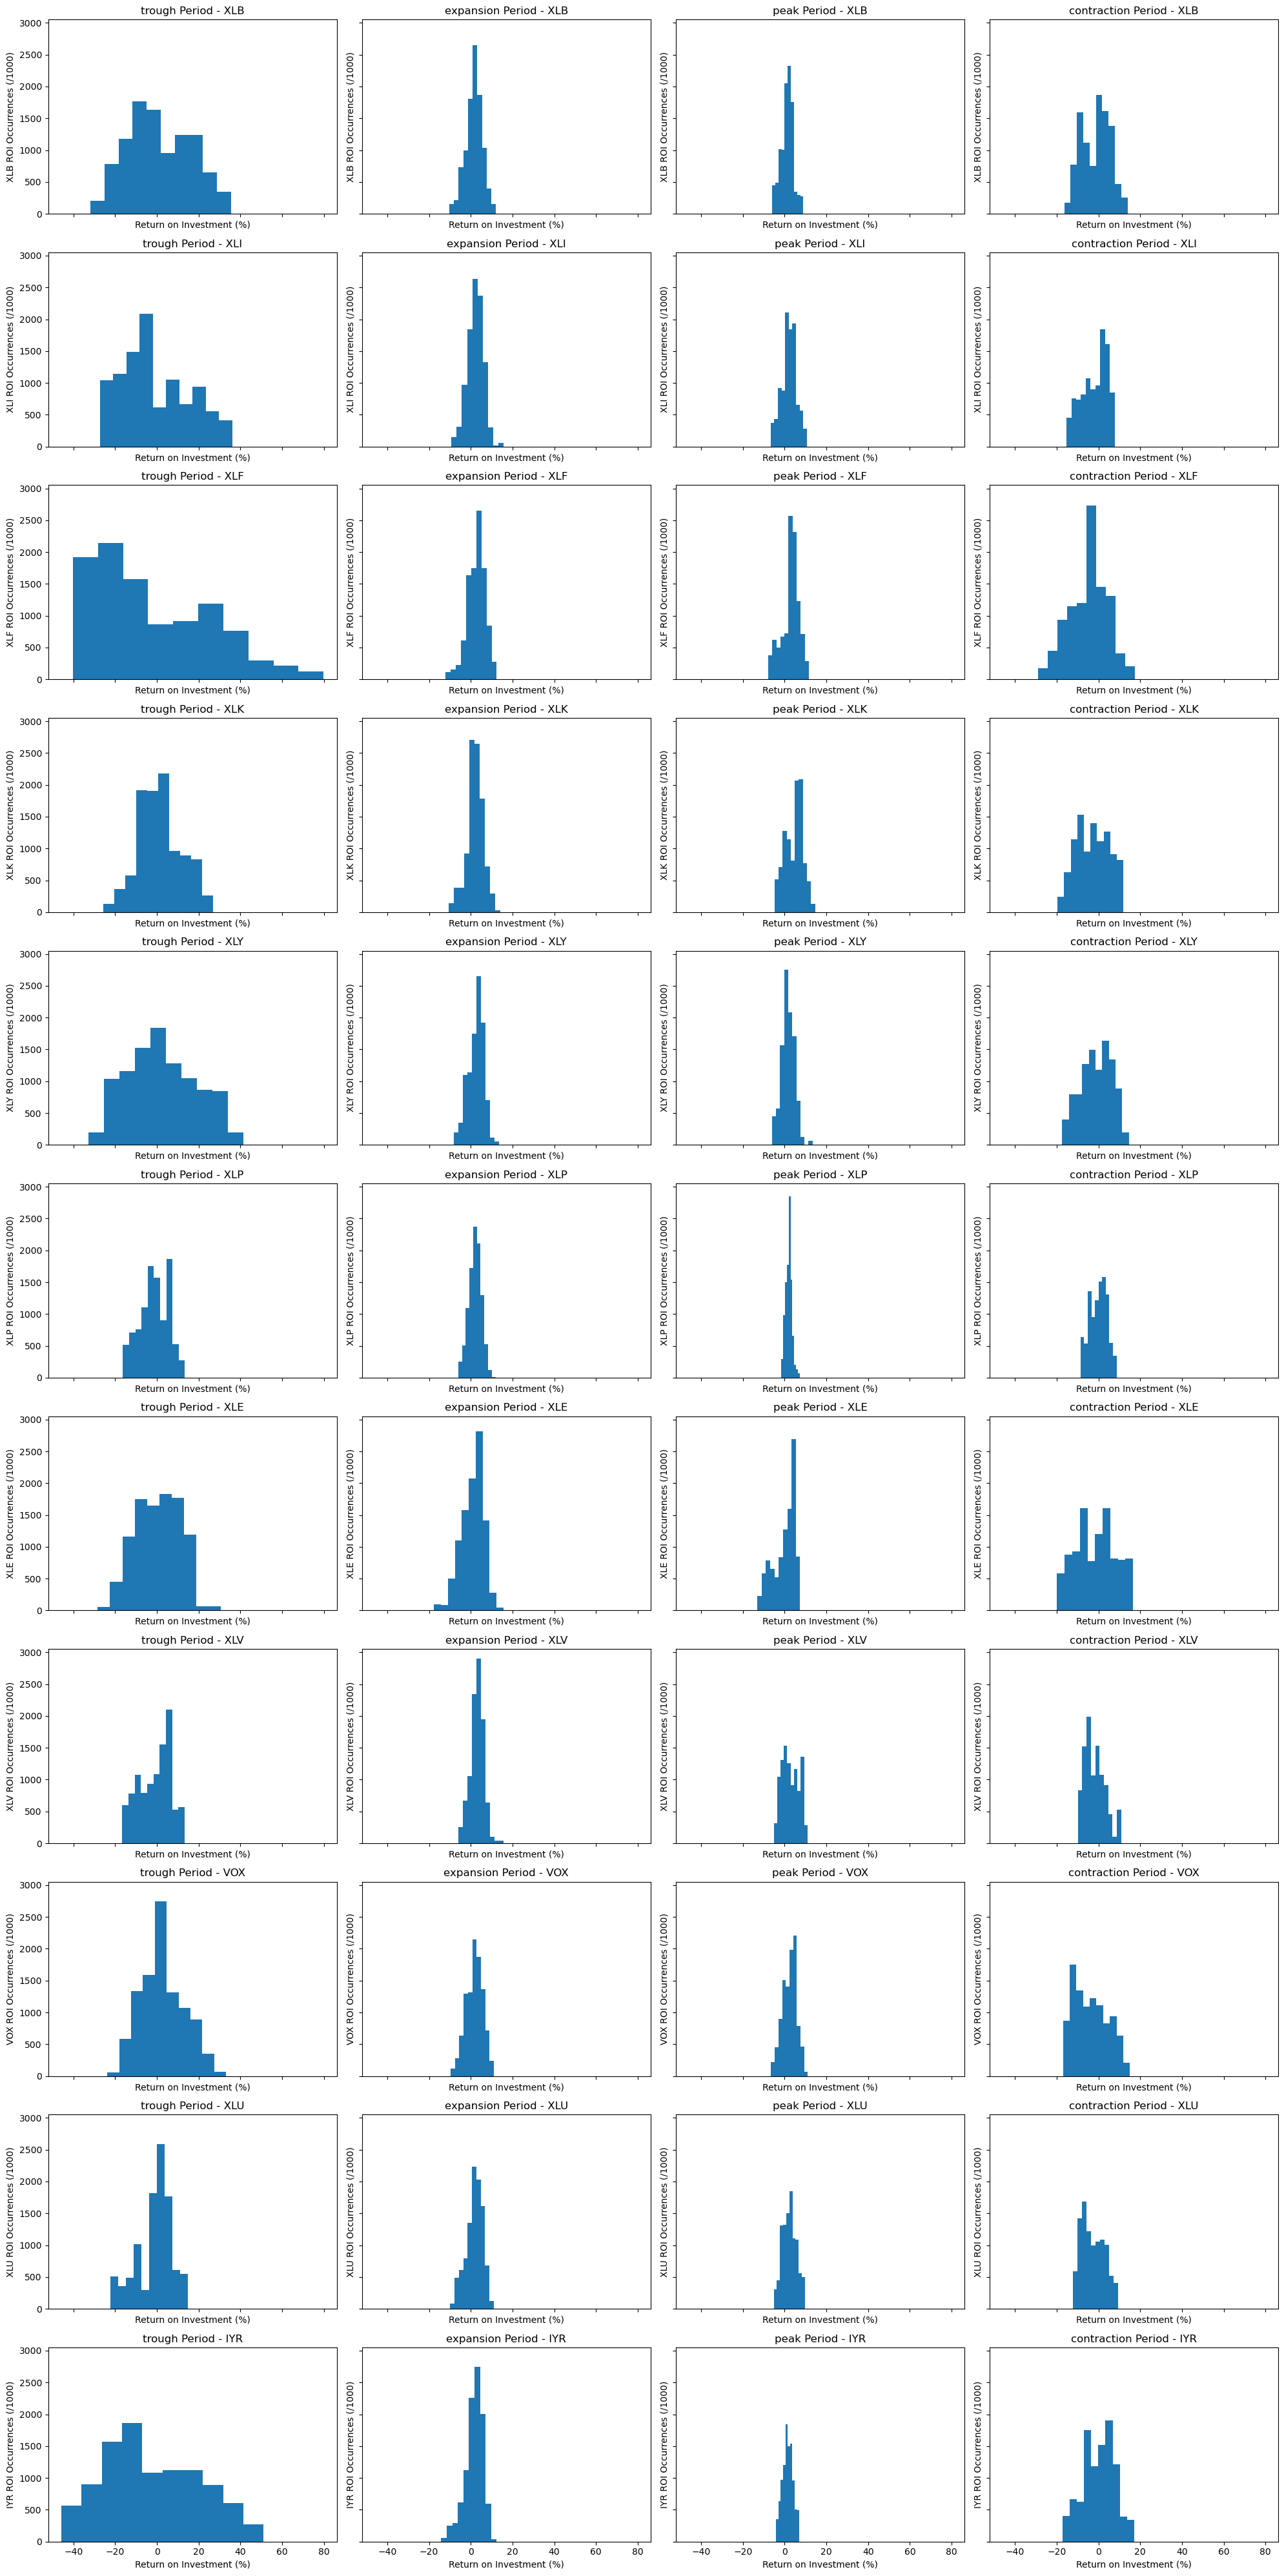

In [31]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplot
rows = len(sector_etf_tickers)
cols = len(economic_cycle_periods_list)

# Create subplots with defined rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(20, 40), sharex=True, sharey=True)

# Loop through periods (columns) and tickers (rows) to create histograms
for i, period in enumerate(economic_cycle_periods_list):
    for j, ticker in enumerate(sector_etf_tickers):
        ax = axes[j, i]  # Access the subplot at position (j, i)
        ax.hist(pd.Series(expected_values_sector_etf_buy_hold[period][ticker]), bins=10)
        ax.set_ylabel(f'{ticker} ROI Occurrences (/1000)', fontsize=10)
        ax.set_xlabel('Return on Investment (%)', fontsize=10)
        ax.set_title(f'{period} Period - {ticker}', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

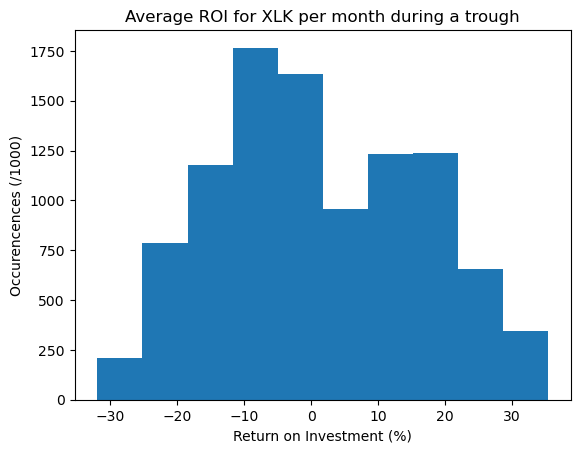

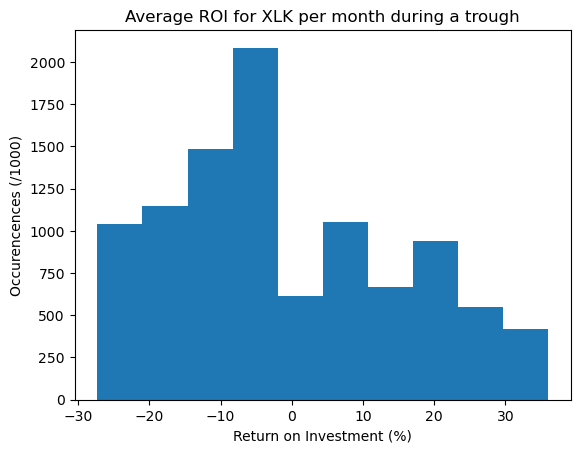

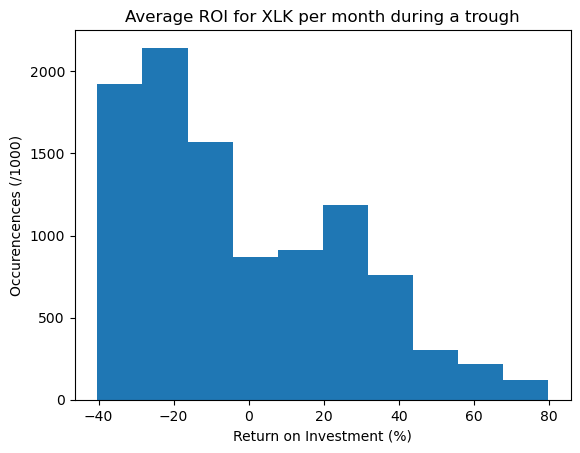

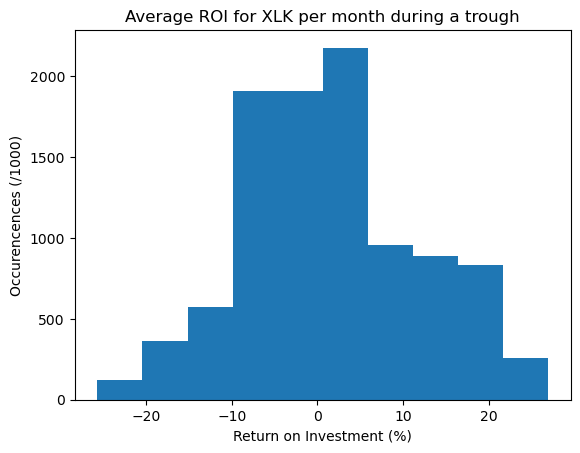

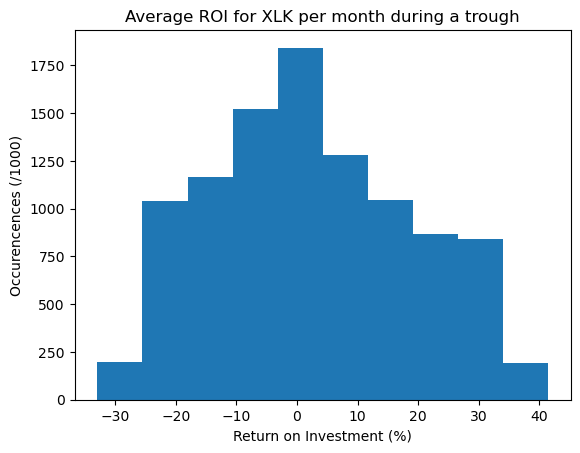

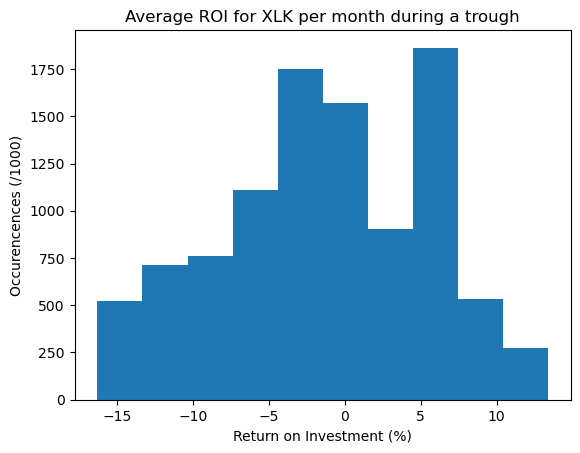

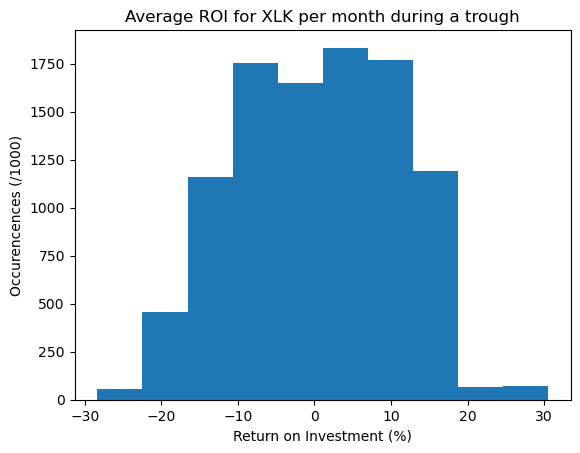

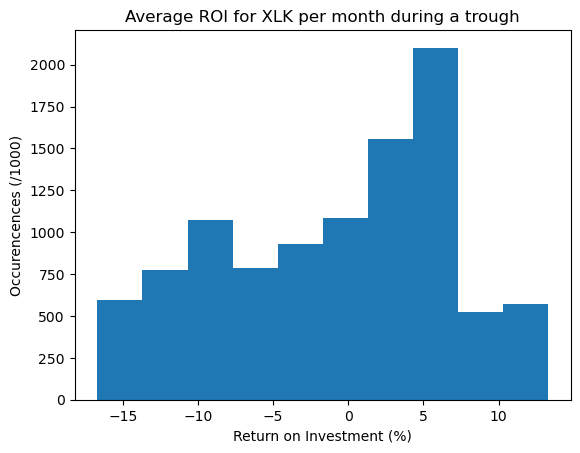

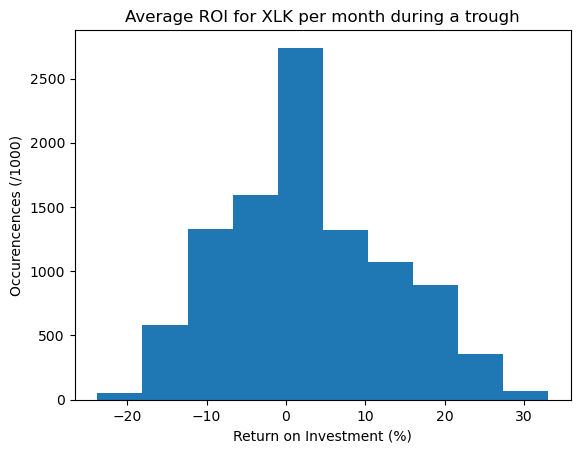

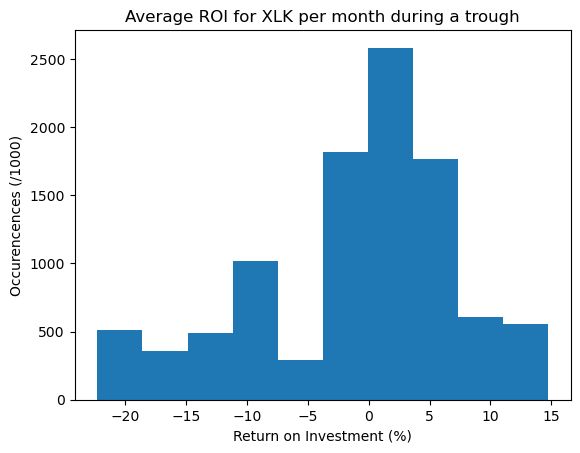

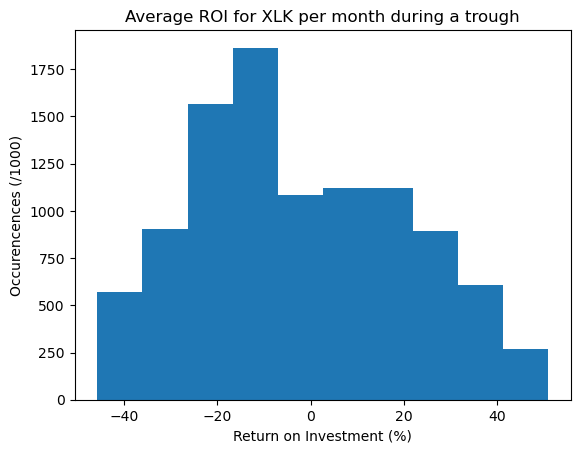

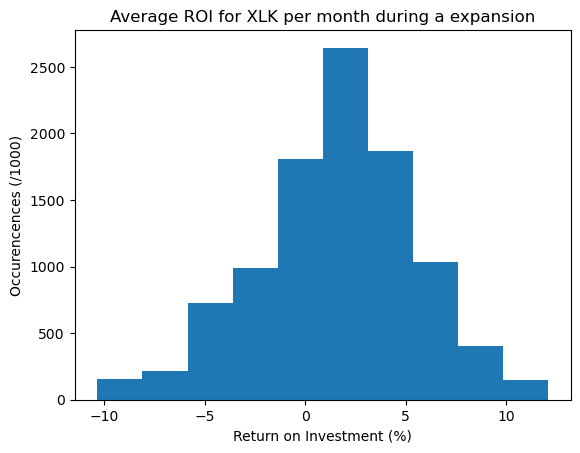

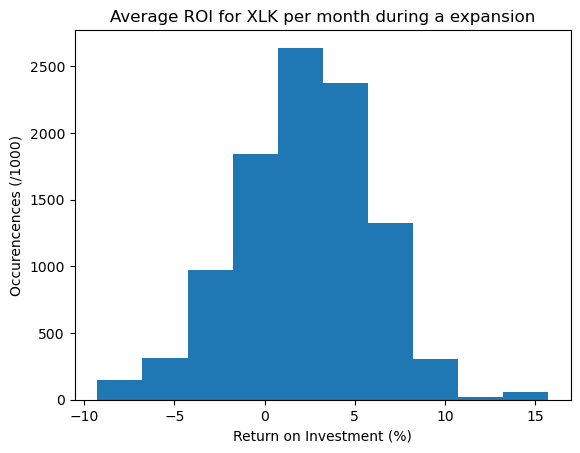

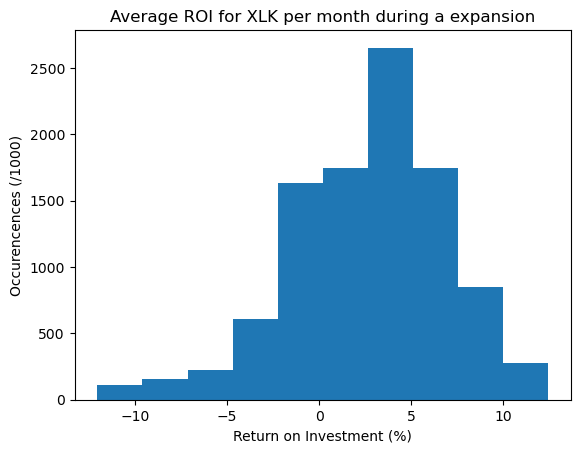

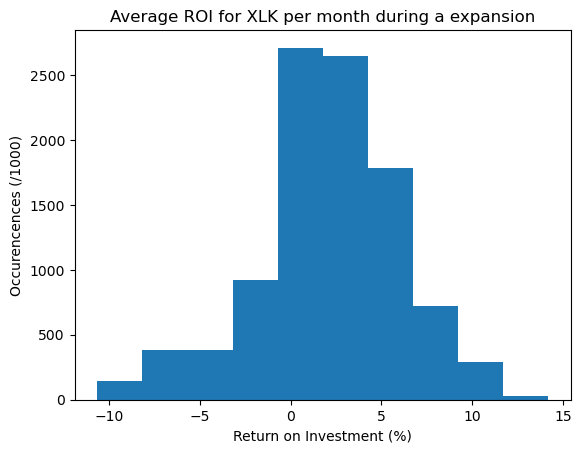

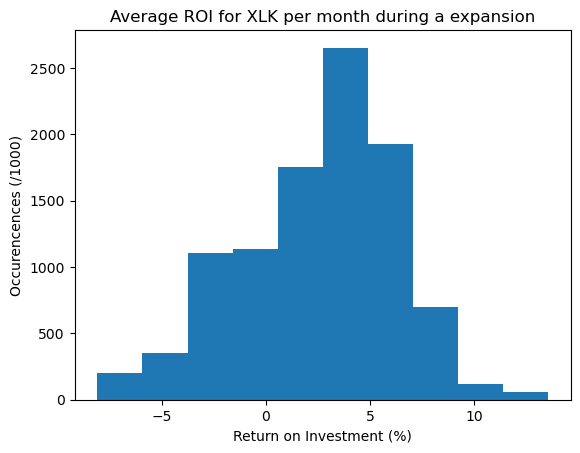

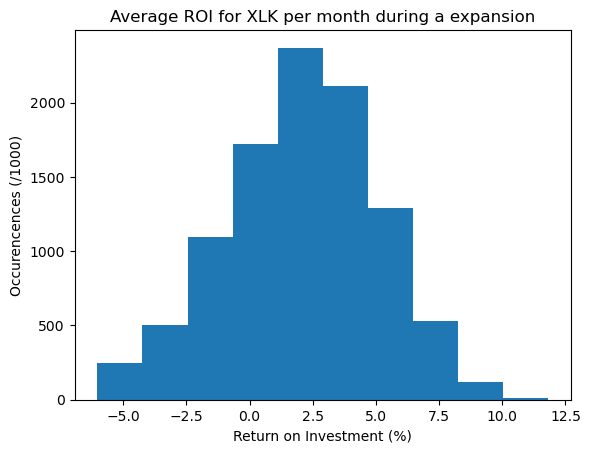

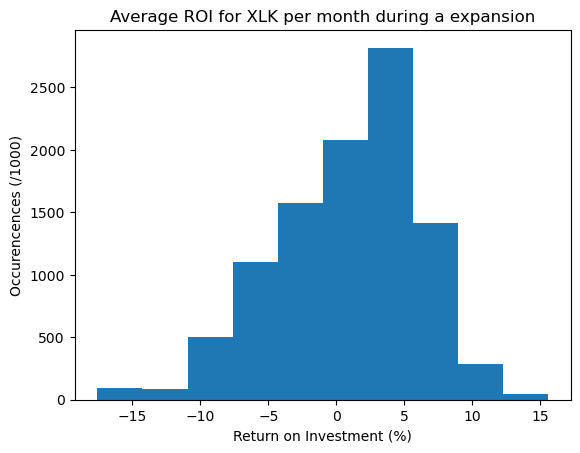

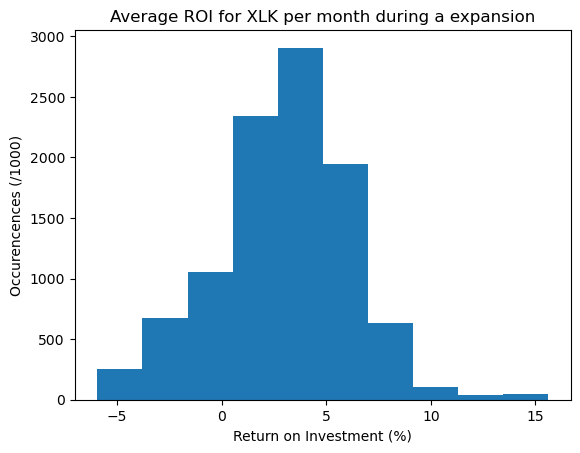

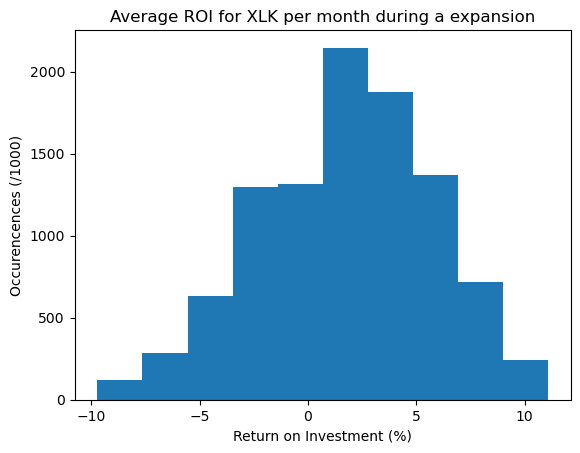

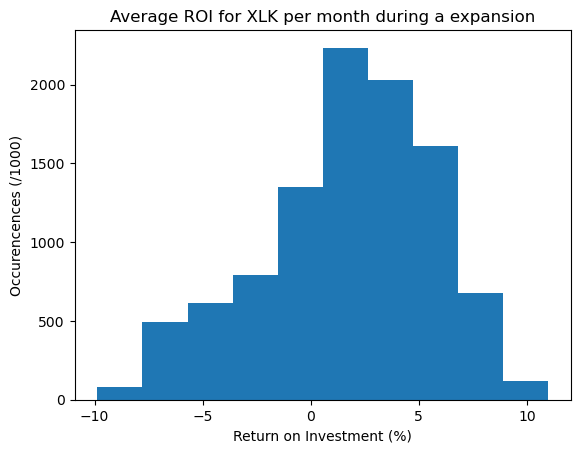

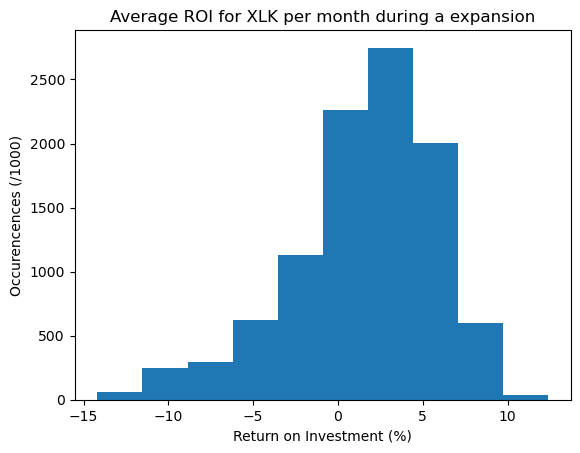

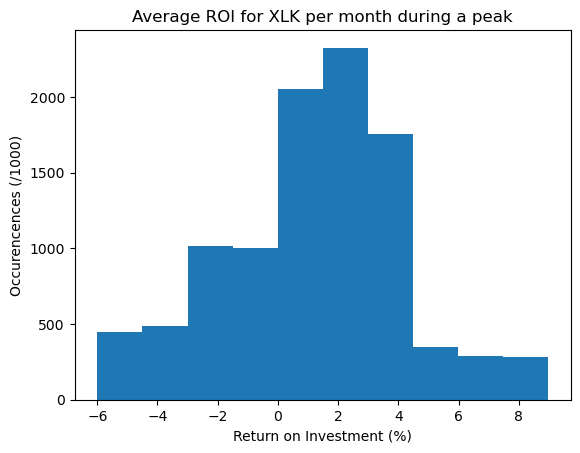

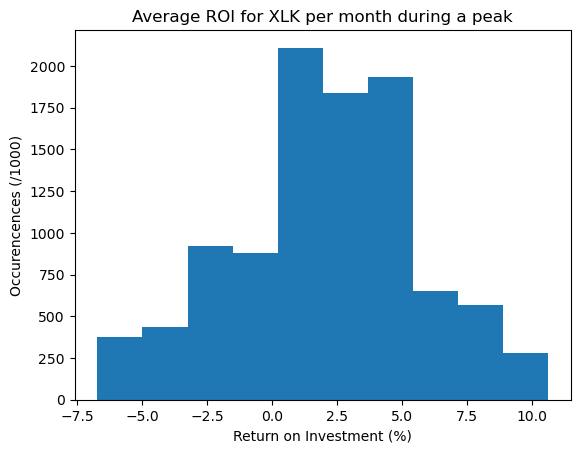

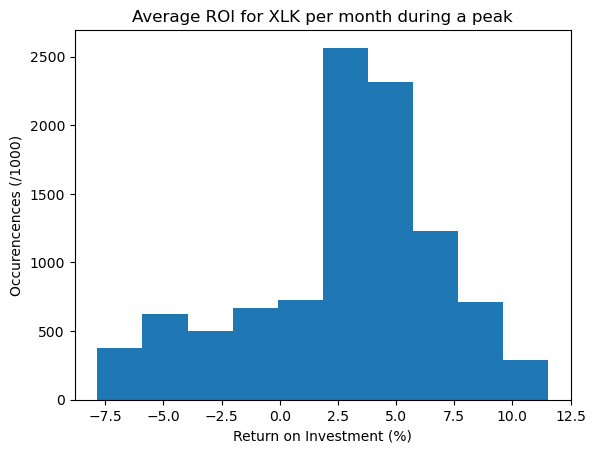

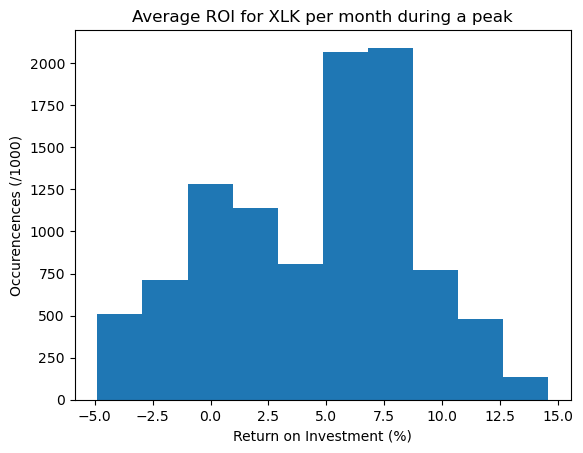

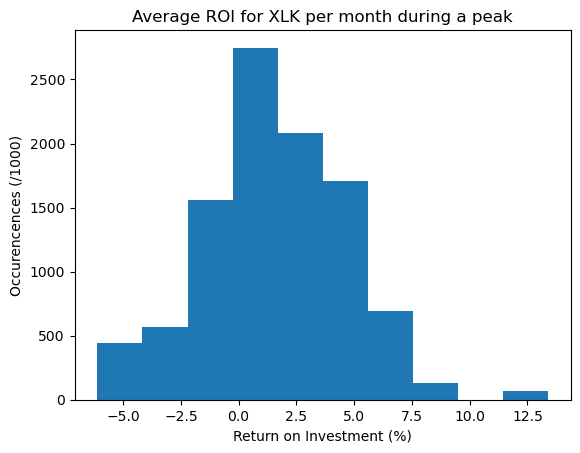

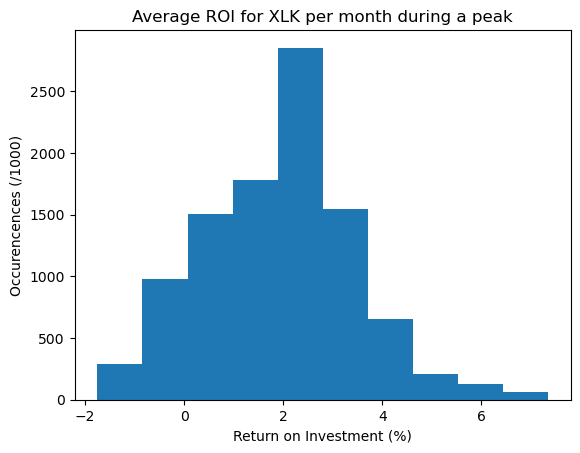

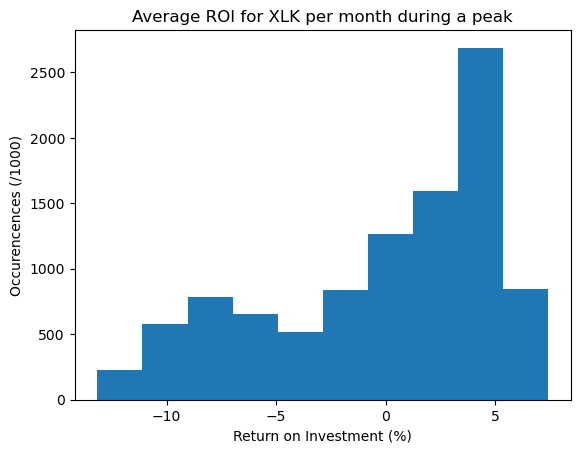

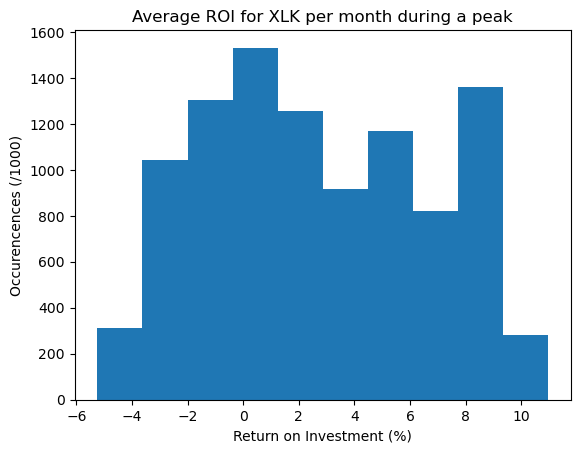

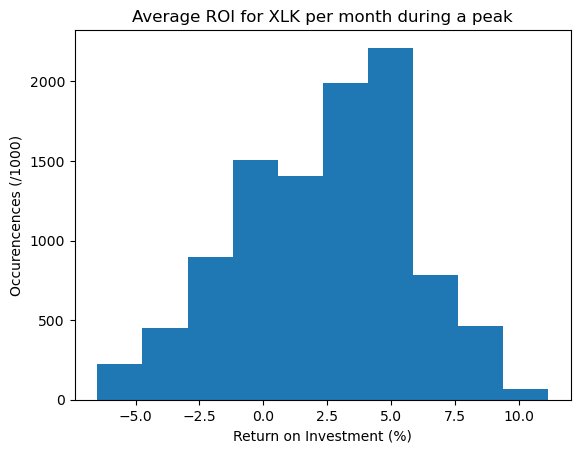

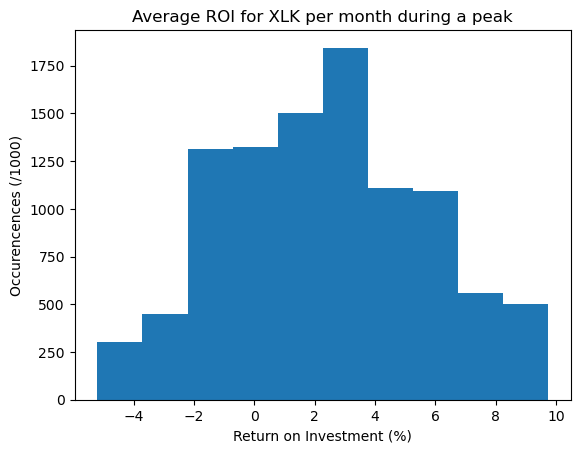

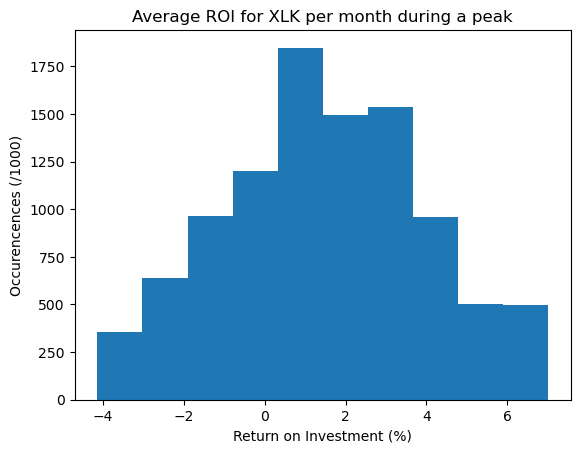

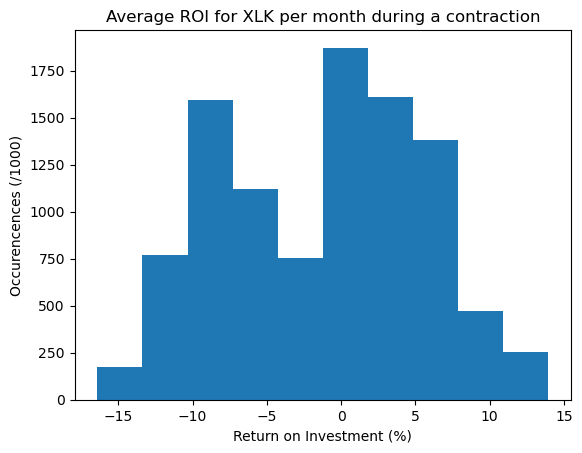

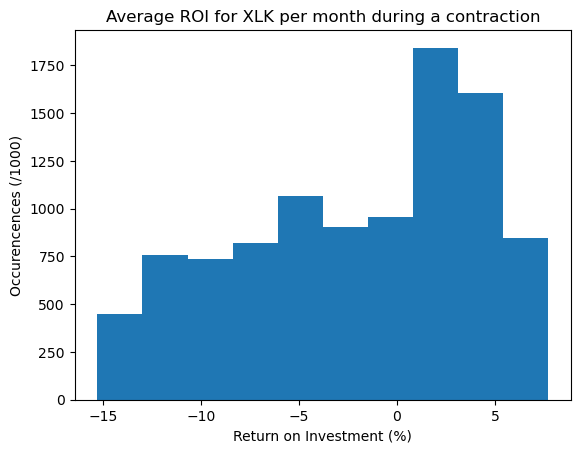

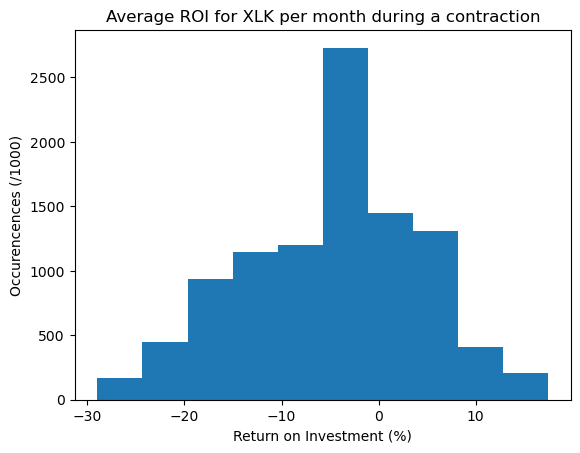

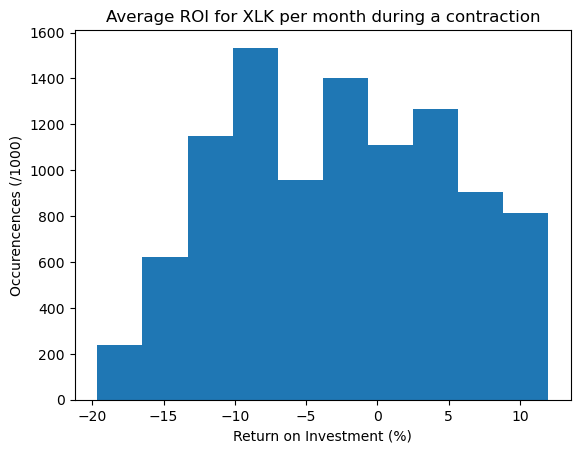

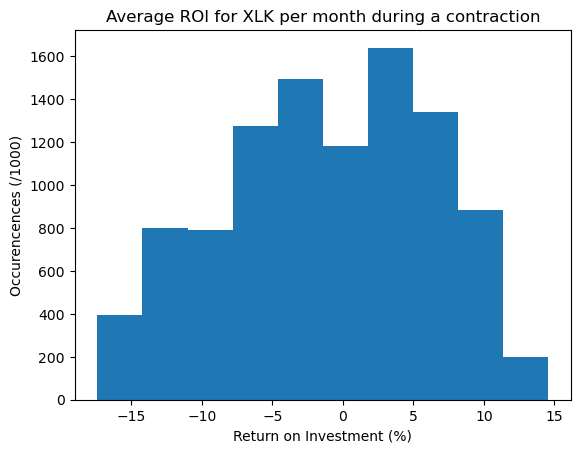

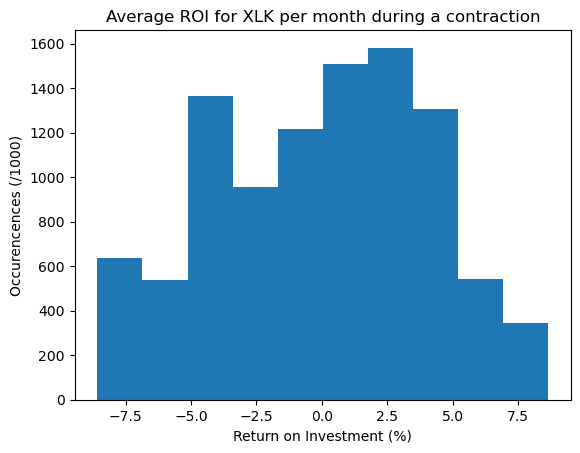

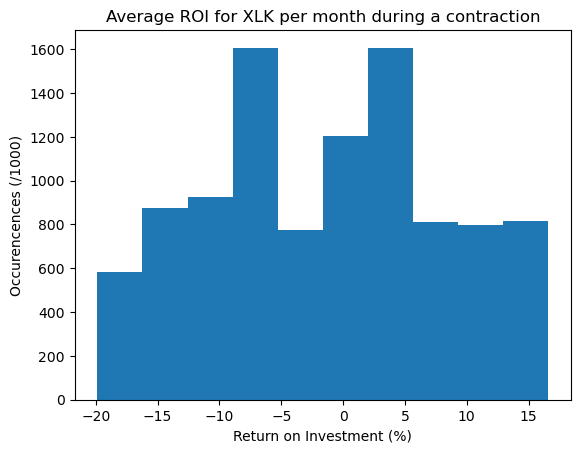

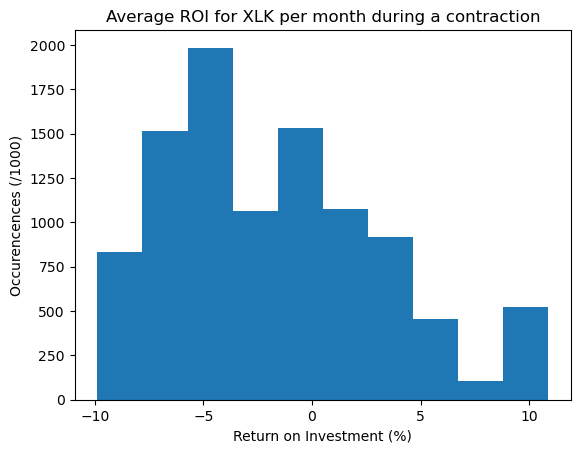

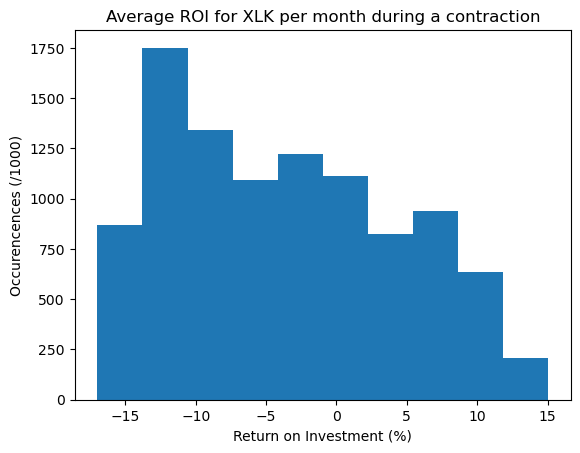

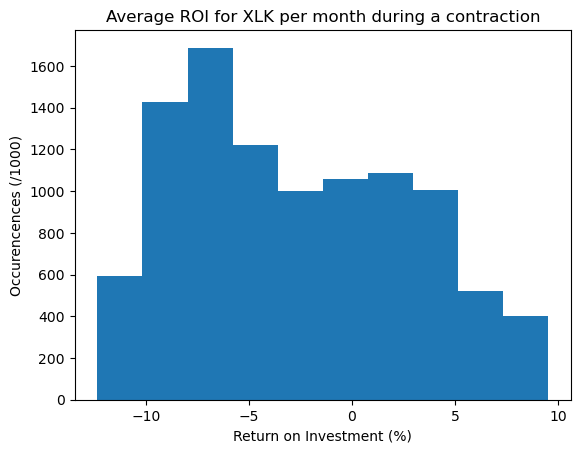

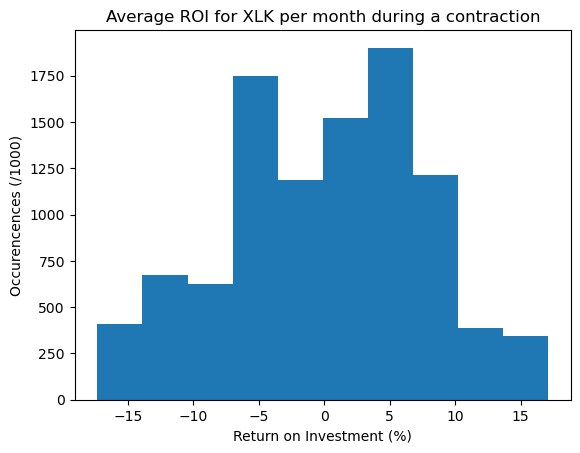

"\nprint('Standard Deviation:')\nprint(pd.Series(expected_values_sector_etf_buy_hold['expansion']['XLK']).std())\nprint('Median:')\nprint(pd.Series(expected_values_sector_etf_buy_hold['expansion']['XLK']).median())\nprint('Mean:')\nprint(pd.Series(expected_values_sector_etf_buy_hold['expansion']['XLK']).mean())"

In [32]:
# example case of expected values by sampling

import matplotlib.pyplot as plt

for period in economic_cycle_periods_list:
        for ticker in sector_etf_tickers:
                plt.hist(pd.Series((expected_values_sector_etf_buy_hold[period][ticker])))
                plt.ylabel('Occurencences (/1000)')
                plt.xlabel('Return on Investment (%)')
                plt.title(f'Average ROI for XLK per month during a {period}')
                plt.show()
"""
print('Standard Deviation:')
print(pd.Series(expected_values_sector_etf_buy_hold['expansion']['XLK']).std())
print('Median:')
print(pd.Series(expected_values_sector_etf_buy_hold['expansion']['XLK']).median())
print('Mean:')
print(pd.Series(expected_values_sector_etf_buy_hold['expansion']['XLK']).mean())"""

The standard deviation is only useful if the data has a normal distribution. None of the data looks to be exactly normal but it looks close to normal.

#### Summarising Expected Results
Create a table for 
- Mean
- Median
- Standard Deviation
- Variation

In [33]:
# find the average return
stochasting_roi(sector_etf_tickers,economic_cycle_periods_list,expected_values_sector_etf_buy_hold,'Mean')

,trough,expansion,peak,contraction
XLB,1.364921,1.556215,1.191834,-1.331868
XLI,-0.776855,2.205372,2.071007,-2.021304
XLF,-2.236235,2.645541,2.778783,-4.668182
XLK,1.624011,2.149849,4.535039,-2.830171
XLY,2.371309,2.533238,1.501043,-1.017577
XLP,-1.371827,2.093837,1.93733,-0.054972
XLE,0.32718,0.840813,-0.082941,-1.303508
XLV,-0.927755,3.050885,2.737736,-1.692395
VOX,2.678619,1.769968,2.482357,-3.537732
XLU,-1.053072,1.721605,2.346083,-2.719458


In [34]:
# find the median return
stochasting_roi(sector_etf_tickers,economic_cycle_periods_list,expected_values_sector_etf_buy_hold,'Median')

,trough,expansion,peak,contraction
XLB,-0.005489,1.634919,1.483406,-0.293152
XLI,-4.152508,2.404192,2.156239,-0.973282
XLF,-11.084534,2.992477,3.533218,-3.426762
XLK,0.799099,2.195388,5.494648,-3.100971
XLY,-0.16806,3.097055,1.375891,-0.436179
XLP,-1.250068,2.257547,2.078757,0.322457
XLE,0.648563,1.715124,1.581731,-0.997598
XLV,0.454025,3.399933,2.054181,-2.821657
VOX,2.137994,1.937297,3.121726,-4.378574
XLU,0.865934,2.126088,2.270941,-3.450979


In [35]:
# find the standard deviation return
stochasting_roi(sector_etf_tickers,economic_cycle_periods_list,expected_values_sector_etf_buy_hold,'Std')


,trough,expansion,peak,contraction
XLB,15.181118,3.942289,3.053788,6.770131
XLI,16.194788,3.722797,3.583573,6.108095
XLF,27.530384,4.234789,4.120359,8.976679
XLK,10.532457,3.940806,4.309507,7.754632
XLY,16.312287,3.703692,3.152908,7.366197
XLP,6.832612,2.99038,1.553945,4.030064
XLE,10.524478,5.338405,5.111625,9.523899
XLV,7.58438,3.191529,4.084219,4.909494
VOX,10.315498,3.930184,3.376973,7.968704
XLU,8.299994,3.961498,3.366044,5.490353


In [36]:
# find the variance return
stochasting_roi(sector_etf_tickers,economic_cycle_periods_list,expected_values_sector_etf_buy_hold,'Variance')


,trough,expansion,peak,contraction
XLB,230.46634,15.541639,9.325621,45.834674
XLI,262.271143,13.859215,12.841998,37.308823
XLF,757.92203,17.933436,16.977356,80.580762
XLK,110.93264,15.529954,18.571854,60.13432
XLY,266.090721,13.717336,9.940826,54.260854
XLP,46.684588,8.942371,2.414745,16.241414
XLE,110.764637,28.498571,26.128708,90.70465
XLV,57.522818,10.185856,16.680848,24.103136
VOX,106.409507,15.446348,11.403945,63.500244
XLU,68.889908,15.693464,11.330254,30.143975


## Bivariate Analysis

In [37]:
# get the correlation for trough
adjusted_close_sector_etf['trough'].corr()

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
XLB,1.000000,0.810805,0.797902,0.926126,0.940810,0.713245,0.805334,0.542796,0.770734,0.365713,0.784803
XLI,0.810805,1.000000,0.930429,0.623732,0.796611,0.955607,0.842349,0.742531,0.490679,0.742070,0.916819
XLF,0.797902,0.930429,1.000000,0.607481,0.733800,0.909901,0.729371,0.615790,0.391562,0.569087,0.928703
XLK,0.926126,0.623732,0.607481,1.000000,0.926798,0.500504,0.700050,0.426963,0.882443,0.222712,0.608412
XLY,0.940810,0.796611,0.733800,0.926798,1.000000,0.684547,0.784799,0.530544,0.866890,0.405505,0.743234
XLP,0.713245,0.955607,0.909901,0.500504,0.684547,1.000000,0.822337,0.773893,0.385345,0.795700,0.896447
XLE,0.805334,0.842349,0.729371,0.700050,0.784799,0.822337,1.000000,0.768463,0.671205,0.750064,0.745820
XLV,0.542796,0.742531,0.615790,0.426963,0.530544,0.773893,0.768463,1.000000,0.379489,0.820144,0.729159
VOX,0.770734,0.490679,0.391562,0.882443,0.866890,0.385345,0.671205,0.379489,1.000000,0.253130,0.401263
XLU,0.365713,0.742070,0.569087,0.222712,0.405505,0.795700,0.750064,0.820144,0.253130,1.000000,0.619811


In [38]:
# get the correlation for expansion
adjusted_close_sector_etf['expansion'].corr()

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
XLB,1.000000,0.986982,0.964635,0.965615,0.962104,0.944093,0.936139,0.970624,0.947038,0.909949,0.840137
XLI,0.986982,1.000000,0.984971,0.959310,0.985469,0.967985,0.912908,0.984149,0.959067,0.918728,0.836886
XLF,0.964635,0.984971,1.000000,0.942745,0.993098,0.983776,0.894998,0.985490,0.973338,0.917892,0.865614
XLK,0.965615,0.959310,0.942745,1.000000,0.935020,0.945932,0.851462,0.972424,0.919687,0.942792,0.873627
XLY,0.962104,0.985469,0.993098,0.935020,1.000000,0.975789,0.898844,0.979892,0.974767,0.898472,0.833315
XLP,0.944093,0.967985,0.983776,0.945932,0.975789,1.000000,0.860943,0.985053,0.971469,0.958003,0.910941
XLE,0.936139,0.912908,0.894998,0.851462,0.898844,0.860943,1.000000,0.867546,0.920449,0.792167,0.744439
XLV,0.970624,0.984149,0.985490,0.972424,0.979892,0.985053,0.867546,1.000000,0.960769,0.953500,0.885828
VOX,0.947038,0.959067,0.973338,0.919687,0.974767,0.971469,0.920449,0.960769,1.000000,0.906095,0.862486
XLU,0.909949,0.918728,0.917892,0.942792,0.898472,0.958003,0.792167,0.953500,0.906095,1.000000,0.943784


In [39]:
# get the correlation for peak
adjusted_close_sector_etf['peak'].corr()

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
XLB,1.000000,0.931061,0.933483,0.831382,0.790433,0.723403,0.534676,0.867563,0.845777,0.477937,0.396946
XLI,0.931061,1.000000,0.975108,0.933171,0.848105,0.831739,0.381272,0.907239,0.926503,0.665890,0.591496
XLF,0.933483,0.975108,1.000000,0.933766,0.830237,0.850623,0.362943,0.933462,0.918713,0.662305,0.573271
XLK,0.831382,0.933171,0.933766,1.000000,0.864236,0.922162,0.194119,0.944126,0.970180,0.792161,0.692274
XLY,0.790433,0.848105,0.830237,0.864236,1.000000,0.824515,0.430289,0.786762,0.911094,0.675355,0.606475
XLP,0.723403,0.831739,0.850623,0.922162,0.824515,1.000000,0.003893,0.830261,0.876923,0.891410,0.833659
XLE,0.534676,0.381272,0.362943,0.194119,0.430289,0.003893,1.000000,0.320859,0.323728,-0.199318,-0.297037
XLV,0.867563,0.907239,0.933462,0.944126,0.786762,0.830261,0.320859,1.000000,0.932945,0.648839,0.537454
VOX,0.845777,0.926503,0.918713,0.970180,0.911094,0.876923,0.323728,0.932945,1.000000,0.717610,0.637115
XLU,0.477937,0.665890,0.662305,0.792161,0.675355,0.891410,-0.199318,0.648839,0.717610,1.000000,0.930607


In [40]:
# get the correlation for contraction
adjusted_close_sector_etf['contraction'].corr()

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
XLB,1.000000,0.754209,0.369504,0.635813,0.515436,0.154849,0.880444,-0.108733,0.492346,0.655536,0.630365
XLI,0.754209,1.000000,0.818386,0.830050,0.868214,0.371537,0.466681,0.384282,0.797639,0.683621,0.707243
XLF,0.369504,0.818386,1.000000,0.647745,0.826996,0.176189,0.051180,0.609219,0.772419,0.557696,0.474916
XLK,0.635813,0.830050,0.647745,1.000000,0.686525,0.502810,0.512872,0.563270,0.939442,0.850614,0.507583
XLY,0.515436,0.868214,0.826996,0.686525,1.000000,0.508089,0.166606,0.462638,0.716775,0.436708,0.746499
XLP,0.154849,0.371537,0.176189,0.502810,0.508089,1.000000,0.019872,0.419488,0.429365,0.170406,0.493934
XLE,0.880444,0.466681,0.051180,0.512872,0.166606,0.019872,1.000000,-0.285928,0.330297,0.637423,0.389374
XLV,-0.108733,0.384282,0.609219,0.563270,0.462638,0.419488,-0.285928,1.000000,0.712223,0.452431,-0.031448
VOX,0.492346,0.797639,0.772419,0.939442,0.716775,0.429365,0.330297,0.712223,1.000000,0.841825,0.408048
XLU,0.655536,0.683621,0.557696,0.850614,0.436708,0.170406,0.637423,0.452431,0.841825,1.000000,0.258033
